In [38]:
import numpy as np
from scipy.sparse.linalg import expm
from scipy.constants import hbar, pi
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

from sim_library.hams import time_evolve, gen_ham_free, gen_ham_plus, gen_ham_minus

# Note: double check these at some point
m = 85.47*1.6605e-27 # Rb-85 mass
kb = 1.38064852e-23 # Boltzmann's constant
omega_2 = 2*pi*(384.230406373e12 - 1.264888e9) # Beam 2 freq.
omega_1 = 2*pi*(384.230406373e12 + 1.770843e9) # Beam 1 freq.
omega_eg = omega_1 - omega_2 # Hyperfine splitting.
k_eff = (omega_1+omega_2)/(2.998e8) # Effective wavevector.
dR = (hbar*(k_eff)**2)/(2*m) # two-photon recoil shift
print(dR/2*pi)

151374.93221726542


In [40]:
class Pulse:
    laser_det: float | np.ndarray
    duration: float
    def __init__(self, laser_det, duration):
        self.laser_det = laser_det
        self.duration = duration

class UpPulse(Pulse):
    phase: float | np.ndarray
    rabi_freq: float | np.ndarray
    type: str
    type_int: int
    def __init__(self, laser_det, phase, rabi_freq, duration):
        super().__init__(laser_det, duration)
        self.phase = phase
        self.rabi_freq = rabi_freq
        self.type = 'up'
        self.type_int = 0

class DownPulse(Pulse):
    phase: float | np.ndarray
    rabi_freq: float | np.ndarray
    type: str
    type_int: int
    def __init__(self, laser_det, phase, rabi_freq, duration):
        super().__init__(laser_det, duration)
        self.phase = phase
        self.rabi_freq = rabi_freq
        self.type = 'down'
        self.type_int = 1

class FreeEvolution(Pulse):
    type: str
    type_int: int
    def __init__(self, laser_det, duration):
        super().__init__(laser_det, duration)
        self.type = 'free'
        self.type_int = 2

class PulseSequence:
    pulses: list
    def __init__(self):
        self.pulses = []

    def add_pulse(self, pulse_object):
        if isinstance(pulse_object, Pulse):
            self.pulses.append(pulse_object)
        else:
            raise TypeError("Only Pulse objects (or subclasses) can be added.")

In [41]:
Rabi_plus = 2*pi*100000
Rabi_minus = 2*pi*100000
Rabi_plus_time = 2*pi/Rabi_plus
Rabi_minus_time = 2*pi/Rabi_minus

pm_seq = PulseSequence()
up_pulse = UpPulse(laser_det=dR, phase=0, rabi_freq=Rabi_plus, duration=Rabi_plus_time/2)
down_pulse = DownPulse(laser_det=-dR, phase=0, rabi_freq=Rabi_plus, duration=Rabi_plus_time/2)

pm_seq.add_pulse(up_pulse)
pm_seq.add_pulse(down_pulse)
pm_seq.add_pulse(up_pulse)
pm_seq.add_pulse(down_pulse)

In [ ]:
def gen_resonant_pm_seq(no_pulses, rabi_freq):
    pulse_seq = PulseSequence()
    for n in range(no_pulses):
        if n % 2 == 0:
            pulse_seq.add_pulse(UpPulse(laser_det=(2*n + 1)*dR, phase=0, rabi_freq=rabi_freq, duration=pi/rabi_freq))
        else:
            pulse_seq.add_pulse(DownPulse(laser_det=-1*(2*n + 1)*dR, phase=0, rabi_freq=rabi_freq, duration=pi/rabi_freq))
    return pulse_seq

In [60]:
pulse_seq2 = gen_resonant_pm_seq(4, rabi_freq=Rabi_plus, dR=dR)

for pulse in pulse_seq2.pulses:
    print(pulse.laser_det/dR)

1.0
-3.0
5.0
-6.999999999999999


In [ ]:
# Pulse Sequence
# n x 6 2d array
# delta_L, phi, rabi_freq, dir (0 for up, 1 for down), pulse_length, free_length

# Defining function to generate the (+-+-) resonant pulse sequence

def gen_resonant_pm_seq(no_pulses, rabi_freq):

    pulse_seq = np.zeros((no_pulses, 6))
    
    for n in range(no_pulses):
        pulse_seq[n,:] = [((-1)**n)*(2*n + 1)*dR, 0, rabi_freq, n % 2, pi/rabi_freq, 0]

    return pulse_seq

pulse_seq1 = gen_resonant_pm_seq(4, 2*pi*100000)


In [57]:
# General func to take in pulse sequence and generate the final momentum distribution
# RNG seed info gets saved so you can reproduce same distribution

def simulate_pulses_p_dist(pulse_seq: PulseSequence, Temp, no_atoms, basis, initial_state):

    rng = np.random.default_rng()
    rng_state = rng.bit_generator.state
    
    sigma = np.sqrt(kb*Temp/m)
    atom_veloc = rng.normal(loc = 0, scale = sigma, size = no_atoms)

    

    data = np.zeros((np.size(basis), np.size(atom_veloc)))

    for v in range(len(atom_veloc)):
        state_vec = initial_state

        for pulse in pulse_seq.pulses:
            
            H0 = gen_ham_free(basis = basis,
                  delta_L = pulse.laser_det, 
                  delta_D = k_eff*atom_veloc[v],
                  delta_R = dR,
            )

            match pulse.type_int:
                case 0:
                    Hint = gen_ham_plus(basis = basis,
                        phi_L = pulse.phase,
                        omega_R_plus = pulse.rabi_freq,
                    )
                    state_vec = time_evolve(pulse.duration, Hint + H0) @ state_vec
                case 1:
                    Hint = gen_ham_minus(basis = basis,
                        phi_L = pulse.phase,
                        omega_R_minus = pulse.rabi_freq,
                    )
                    state_vec = time_evolve(pulse.duration, Hint + H0) @ state_vec
                case 2:
                    state_vec = time_evolve(pulse.duration, H0) @ state_vec
            
                
            

        
        square = np.abs(state_vec)**2
        data[:,v] = square


    init_mom_dist = atom_veloc*m
    init_mom_dist_tiled = np.tile(init_mom_dist, (len(basis),1))

    basis_tiled = np.transpose(np.tile(basis, (len(atom_veloc),1)))

    final_mom_dist_tiled = init_mom_dist_tiled + (hbar*k_eff*basis_tiled)

    final_mom_dist = np.ravel(final_mom_dist_tiled)

    state_fractions = np.ravel(data)
    
    return final_mom_dist, state_fractions, init_mom_dist, rng_state

# simulate_pulses(pulse_seq1, 10e-6, 1, np.array([0,1,2,3,4]), np.array([1,0,0,0,0]))





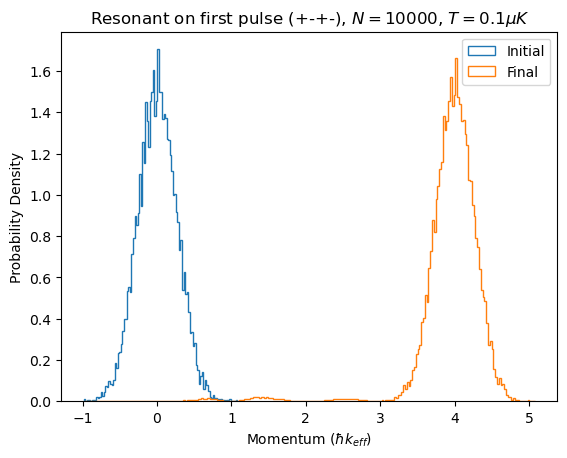

In [59]:
N = 10000
Temp = 0.1e-6

final, fracs, init, _ = simulate_pulses_p_dist(pulse_seq2, Temp, N, np.array([0,1,2,3,4]), np.array([1,0,0,0,0]))

final = final/(hbar*k_eff)
init = init/(hbar*k_eff)

plt.hist(x = init, bins = 100, histtype='step',density=True,label='Initial')
plt.hist(x = final, bins = 250, weights=fracs, histtype='step',density=True, label='Final')
plt.title(rf"Resonant on first pulse (+-+-), $N={N}$, $T={Temp*1e6:.3g}\mu K$")
plt.ylabel('Probability Density')
plt.xlabel(r"Momentum ($\hbar k_{eff}$)")
plt.legend()
plt.show()